In [1]:
# PRIPOJENI K DB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sqlalchemy import create_engine


import urllib.parse

# Zakódování connection stringu
params = urllib.parse.quote_plus(
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=localhost;"
    "Database=VALUO;"
    "Trusted_Connection=yes"
)

# Vytvoření SQLAlchemy engine
connection_url = f"mssql+pyodbc:///?odbc_connect={params}"
engine = create_engine(connection_url)


In [2]:
query = """

  -- Intervaly pro typ 'byt'
DECLARE @byt_price_lower INT = 2500000;
DECLARE @byt_price_upper INT = 30000000;
DECLARE @byt_area_lower DECIMAL(10,2) = 15;
DECLARE @byt_area_upper DECIMAL(10,2) = 300;

WITH main AS (
    SELECT
        -- Unikátní číslo řízení
        cislo_vkladu,

        -- Základní údaje – používáme MAX, protože předpokládáme shodné hodnoty pro dané `cislo_vkladu`
        MAX(CAST(listina AS VARCHAR(MAX)))         AS listina,
        MAX(datum_podani)                           AS datum_podani,
        MAX(rok)                                    AS rok,
        MAX(mesic)                                  AS mesic,
        MAX(okres)                                  AS okres,
        MAX(kat_uzemi)                              AS kat_uzemi,
        MAX(CAST(adresa AS VARCHAR(MAX)))           AS adresa,
        MAX(LAT)                                    AS LAT,
        MAX(LON)                                    AS LON,
        MAX(mena)                                   AS mena,
        FLOOR(MAX(cenovy_udaj))                     AS cenovy_udaj,

        -- Počet nemovitostí v rámci `cislo_vkladu`, kde typ = 'byt'
        COUNT(*)                                    AS [#_NEMOVITOSTI],

        -- Filtrace pouze na 'byt'
        SUM(CASE WHEN typ = 'byt' THEN 1 ELSE 0 END) AS [#_byt],

        -- Celková plocha pro byty
        ROUND(SUM(CASE WHEN typ = 'byt' THEN plocha ELSE 0 END), 2) AS A_byt,

        -- Typ nemovitosti
        'byt' AS TYP,

        -- Jednotky měření
        '[m2]' AS MJ,

        -- Celkový počet jednotek měření pro 'byt'
        ROUND(SUM(CASE WHEN typ = 'byt' THEN plocha ELSE 0 END), 2) AS POCET_MJ,

        -- Jednotková cena (JEDNOTKOVÁ CENA = MAX(cenovy_udaj) / celková plocha)
        CASE 
            WHEN SUM(CASE WHEN typ = 'byt' THEN plocha ELSE 0 END) > 0 
            THEN CAST(ROUND(MAX(cenovy_udaj)*1.0 / NULLIF(SUM(CASE WHEN typ = 'byt' THEN plocha ELSE 0 END), 0), 0) AS INT)
            ELSE NULL
        END AS JC
    FROM [valuo].[dbo].[valuo_data]
    WHERE typ = 'byt' 
      AND okres = 'Hlavní město Praha'  -- Přidaná podmínka pro okres
      AND LAT IS NOT NULL
      AND LON IS NOT NULL
    GROUP BY cislo_vkladu
    HAVING 
        -- Podmínka: zobrazit pouze záznamy, kde počet nemovitostí je 1
        COUNT(*) = 1
        -- Podmínky na platné hodnoty pro byty
        AND MIN(cenovy_udaj) >= @byt_price_lower
        AND MAX(cenovy_udaj) <= @byt_price_upper
        AND MIN(plocha) >= @byt_area_lower
        AND MAX(plocha) <= @byt_area_upper
)
-- Finální výstup s doplněním concatenovaných sloupců
SELECT 
    m.*,
    STUFF(
        (SELECT ' || ' + ISNULL(t.typ_plochy, '')
         FROM [valuo].[dbo].[valuo_data] t
         WHERE t.cislo_vkladu = m.cislo_vkladu
         FOR XML PATH(''), TYPE
        ).value('.', 'NVARCHAR(MAX)'), 1, 4, ''
    ) AS typ_plochy,
    STUFF(
        (SELECT ' || ' + ISNULL(t.popis, '')
         FROM [valuo].[dbo].[valuo_data] t
         WHERE t.cislo_vkladu = m.cislo_vkladu
         FOR XML PATH(''), TYPE
        ).value('.', 'NVARCHAR(MAX)'), 1, 4, ''
    ) AS popis
FROM main m;


  """

# Získání dat z databáze  


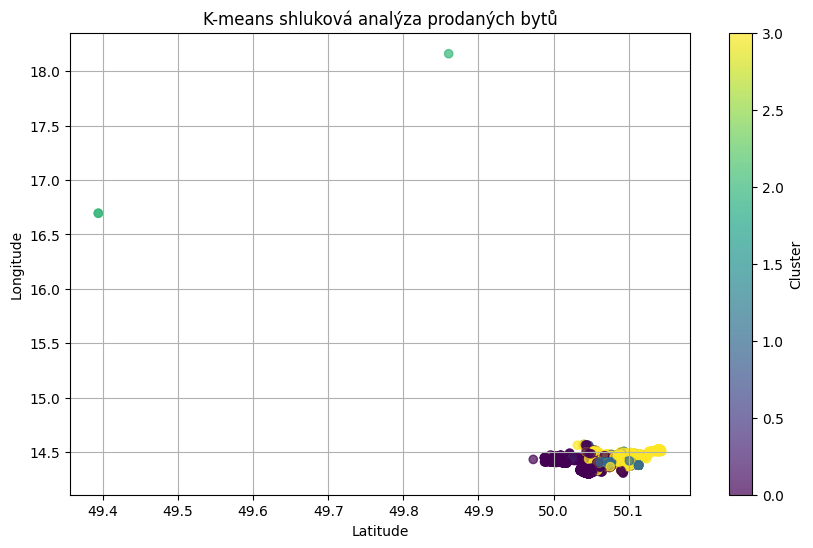

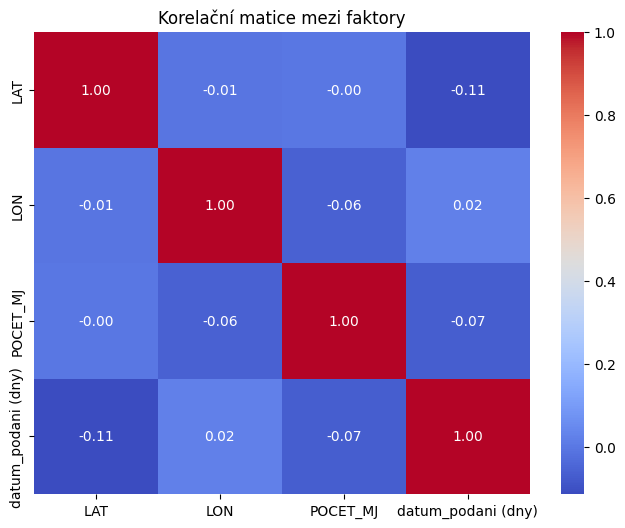

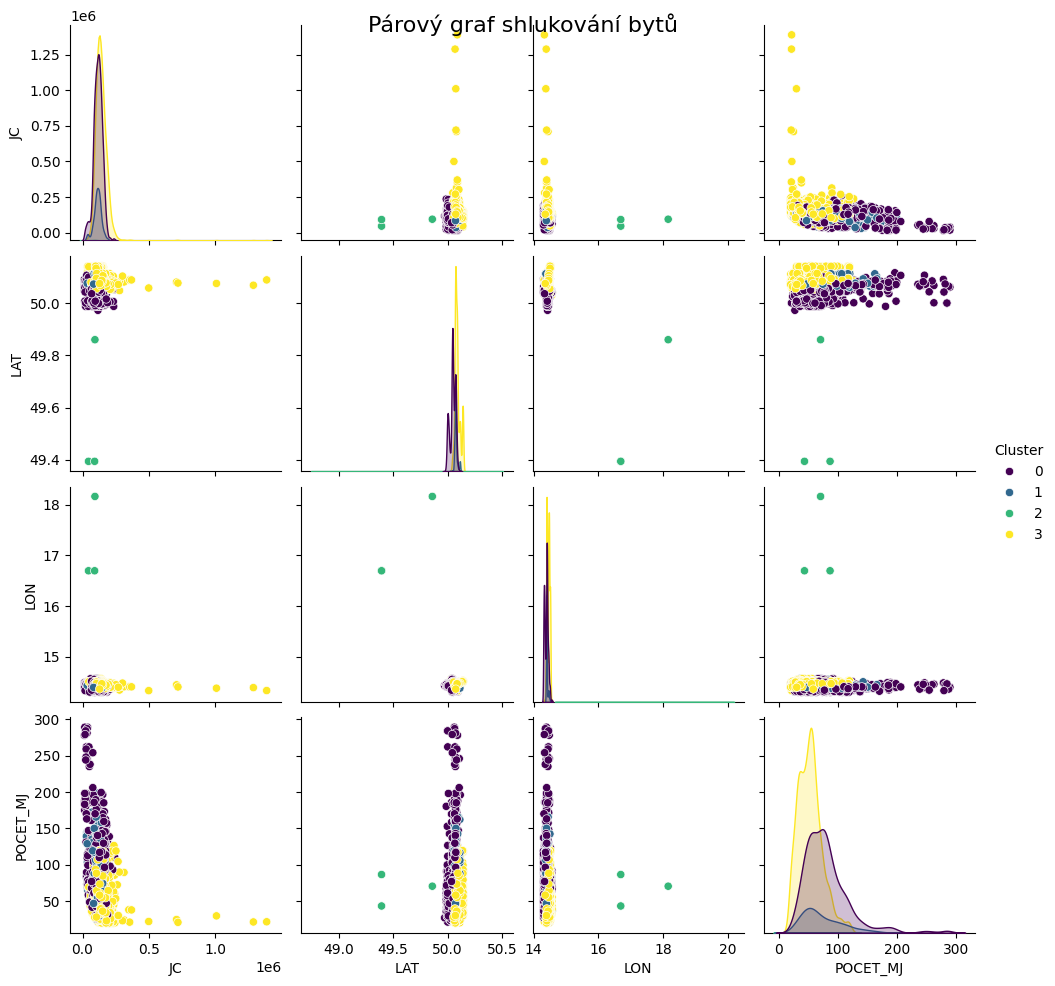


📊 Výsledky modelů:
Lineární regrese: R² = 0.052, MSE = 4039732727.22


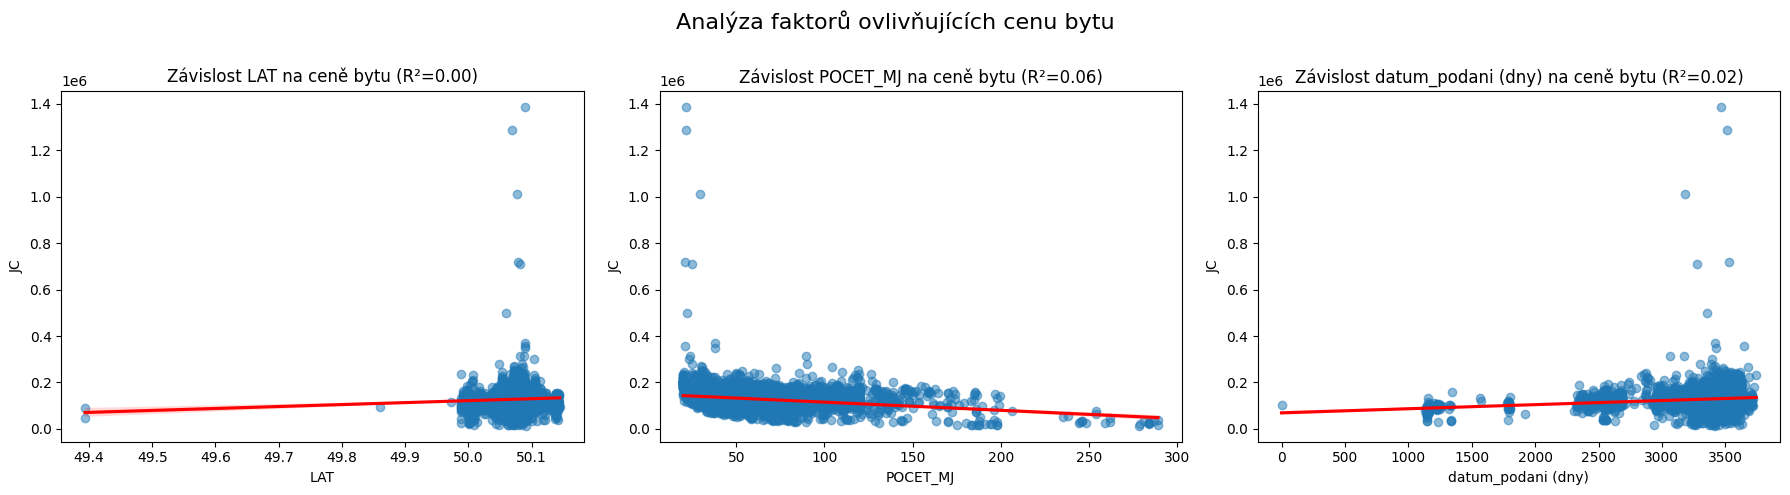

In [3]:

def analyze_real_estate_data(engine, query, enable_visuals=True, pairplot_vars=None):
    """
    Analyzuje data o cenách bytů v Praze, provádí shlukovou analýzu a predikuje ceny.
    :param engine: Připojení k databázi.
    :param query: SQL dotaz pro načtení dat.
    :param enable_visuals: Ovládání vizualizací pro rychlejší běh.
    :param pairplot_vars: Seznam sloupců pro párový graf (volitelné).
    """
    # 1️⃣ Načtení dat z databáze
    df = pd.read_sql(query, engine)


    # Ověření, zda jsou požadované sloupce v datech
    required_columns = ['datum_podani', 'LAT', 'LON', 'JC', 'POCET_MJ']
    missing_columns = [col for col in required_columns if col not in df.columns]

    if missing_columns:
        raise ValueError(f"Chybějící sloupce v datech: {missing_columns}")

    # Převod data na datetime a výpočet dnů od začátku
    df['datum_podani'] = pd.to_datetime(df['datum_podani'], dayfirst=True, errors='coerce')
    df['datum_podani (dny)'] = (df['datum_podani'] - df['datum_podani'].min()).dt.days

    # Odstranění řádků s chybějícími hodnotami
    df = df.dropna(subset=['LAT', 'LON', 'JC', 'POCET_MJ', 'datum_podani (dny)'])

    # 2️⃣ Normalizace dat pro K-means
    scaler = StandardScaler()
    #features = ['LAT', 'LON', 'JC', 'POCET_MJ', 'datum_podani (dny)']
    #X_scaled = scaler.fit_transform(df[features])

    features = ['LAT', 'LON', 'POCET_MJ', 'datum_podani (dny)']  # Odstraněn sloupec 'JC'
    X_scaled = scaler.fit_transform(df[features + ['JC']])  # Přidán sloupec 'JC' pro normalizaci

    # 3️⃣ Shluková analýza (K-means)
    k = 4
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto', max_iter=300)
    df['Cluster'] = kmeans.fit_predict(X_scaled)

    if enable_visuals:
        # 4️⃣ Vizualizace shluků podle polohy
        plt.figure(figsize=(10, 6))
        plt.scatter(df['LAT'], df['LON'], c=df['Cluster'], cmap='viridis', marker='o', alpha=0.7)
        plt.xlabel('Latitude')
        plt.ylabel('Longitude')
        plt.title('K-means shluková analýza prodaných bytů')
        plt.colorbar(label='Cluster')
        plt.grid(True)
        plt.show()

        # 5️⃣ Korelační analýza
        plt.figure(figsize=(8, 6))
        sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
        plt.title('Korelační matice mezi faktory')
        plt.show()

        # 6️⃣ Párový graf pro shlukování
        if pairplot_vars:
            selected_vars = [var for var in pairplot_vars if var in df.columns]
        else:
            selected_vars = ['LAT', 'LON', 'JC', 'POCET_MJ', 'datum_podani (dny)']

        sampled_df = df.sample(n=min(5000, len(df)), random_state=42)
        sns.pairplot(sampled_df[selected_vars + ['Cluster']], hue='Cluster', diag_kind='kde', palette='viridis')
        plt.suptitle('Párový graf shlukování bytů', fontsize=16)
        plt.show()

    # 7️⃣ Predikce cen bytů
    X = df[['LAT', 'LON', 'POCET_MJ', 'datum_podani (dny)']]
    y = df['JC']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Model 1: Lineární regrese
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred_lr = lin_reg.predict(X_test)
    r2_lr = r2_score(y_test, y_pred_lr)

    # Model 2: Random Forest
    rf_reg = RandomForestRegressor(n_estimators=50, random_state=42)
    rf_reg.fit(X_train, y_train)
    y_pred_rf = rf_reg.predict(X_test)
    r2_rf = r2_score(y_test, y_pred_rf)

    print("\n📊 Výsledky modelů:")
    print(f"Lineární regrese: R² = {r2_lr:.3f}, MSE = {mean_squared_error(y_test, y_pred_lr):.2f}")
    #axes[i].set_ylabel('JC')

    if enable_visuals:
        # 8️⃣ Grafy závislostí faktorů na ceně včetně R²
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        factors = ['LAT', 'POCET_MJ', 'datum_podani (dny)']

        for i, factor in enumerate(factors):
            sns.regplot(ax=axes[i], x=df[factor], y=df['JC'], line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5})
            r2 = r2_score(df['JC'], LinearRegression().fit(df[[factor]], df['JC']).predict(df[[factor]]))
            axes[i].set_title(f'Závislost {factor} na ceně bytu (R²={r2:.2f})')
            axes[i].set_ylabel('JC')

        plt.suptitle('Analýza faktorů ovlivňujících cenu bytu', fontsize=16)
        plt.tight_layout()
        plt.show()

    return df

vybrane_sloupce = ['JC', 'LAT', 'LON', 'POCET_MJ', 'datum_podan (dny)']
df = analyze_real_estate_data(engine, query, enable_visuals=True, pairplot_vars=vybrane_sloupce)

